In [1]:

from sklearn.model_selection import KFold

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

EDA (Exploratory Data Analysis)

In [3]:
# Checking the number of rows (records) and columns (features)
print("Train Image Shape ".ljust(20, "-"), train_images.shape)
print("Train Label Shape ".ljust(20, "-"),train_labels.shape)
print("Test Image Shape ".ljust(20, "-"),test_images.shape)
print("Test Label Shape ".ljust(20, "-"),test_labels.shape)

Train Image Shape -- (50000, 32, 32, 3)
Train Label Shape -- (50000, 1)
Test Image Shape --- (10000, 32, 32, 3)
Test Label Shape --- (10000, 1)


In [4]:
print("Unique Train Labels ".ljust(24, "-"), np.unique(train_labels))
print("Unique Test Labels ".ljust(24, "-"), np.unique(test_labels))

Unique Train Labels ---- [0 1 2 3 4 5 6 7 8 9]
Unique Test Labels ----- [0 1 2 3 4 5 6 7 8 9]


In [5]:
# A list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

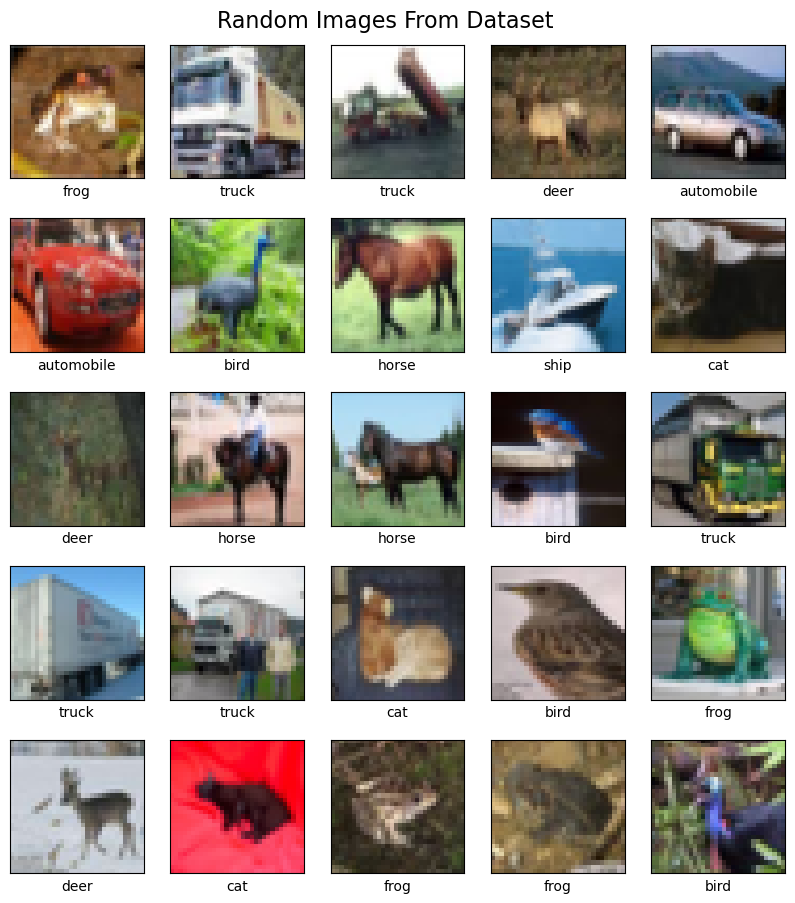

In [6]:
# Visualizing some of the images from the training dataset
fig = plt.figure(figsize=[10,10])
fig.suptitle('Random Images From Dataset', fontsize=16)  # Add global title
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i][0]])

plt.subplots_adjust(top=0.95)
plt.show()

Data Preprocessing
- convert all pixel values to values between 0 and 1.
- one hot encoding (target classes)

In [7]:
# Converting the pixels data to float type
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Standardizing (255 is the total number of pixels an image can have)
train_images = train_images / 255
test_images = test_images / 255 

# One hot encoding the target class (labels)
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [8]:
def create_model():
    model = Sequential()

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(None,None,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.GlobalAveragePooling2D())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model


def compile_model(model):
    loss_fn = keras.losses.categorical_crossentropy
    optimizer=keras.optimizers.legacy.Adam()

    model.compile(optimizer=optimizer,
                loss=loss_fn,
                metrics=["accuracy"])
    return model


In [9]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
all_histories = []  # Store training histories for all folds
for fold, (train_indices, val_indices) in enumerate(kf.split(train_images)):
    print("-" * 40)
    print(f"\033[1;34mFold \033[1;31m{fold + 1}/{num_folds}\033[0m") 
    print("-" * 40)
    # Create a new instance of the model for each fold
    model = create_model()
    # Compile the model
    model = compile_model(model)
    # Prepare training and validation data for the current fold
    x_train_fold = train_images[train_indices]
    y_train_fold = train_labels[train_indices]

    x_val_fold = train_images[val_indices]
    y_val_fold = train_labels[val_indices]

    # Train the model on the current fold
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit(train_images, train_labels, batch_size=128, epochs=100,
                    validation_data=(test_images, test_labels), callbacks=[early_stopping])
    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_images)
    print(f"\nTest accuracy for fold {fold + 1}: {test_acc * 100:.2f}%")
    all_histories.append(history)



----------------------------------------
Fold 1/5
----------------------------------------


2024-01-29 00:12:58.744065: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-29 00:12:58.744096: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-29 00:12:58.744109: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-29 00:12:58.744155: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-29 00:12:58.744175: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-01-29 00:13:01.289420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - 20s 46ms/step - loss: 1.7699 - accuracy: 0.3874 - val_loss: 3.1855 - val_accuracy: 0.1783
Epoch 2/100
391/391 [==============================] - 17s 44ms/step - loss: 1.1982 - accuracy: 0.5709 - val_loss: 1.2461 - val_accuracy: 0.5623
Epoch 3/100
391/391 [==============================] - 17s 44ms/step - loss: 1.0292 - accuracy: 0.6325 - val_loss: 1.0424 - val_accuracy: 0.6320
Epoch 4/100
391/391 [==============================] - 17s 44ms/step - loss: 0.9337 - accuracy: 0.6678 - val_loss: 0.8457 - val_accuracy: 0.6900
Epoch 5/100
391/391 [==============================] - 17s 44ms/step - loss: 0.8680 - accuracy: 0.6926 - val_loss: 0.9220 - val_accuracy: 0.6750
Epoch 6/100
391/391 [==============================] - 18s 46ms/step - loss: 0.8109 - accuracy: 0.7167 - val_loss: 0.8071 - val_accuracy: 0.7147
Epoch 7/100
391/391 [==============================] - 18s 47ms/step - loss: 0.7588 - accuracy: 0.7350 - val_loss: 0.8689 - val_accuracy: 0.70

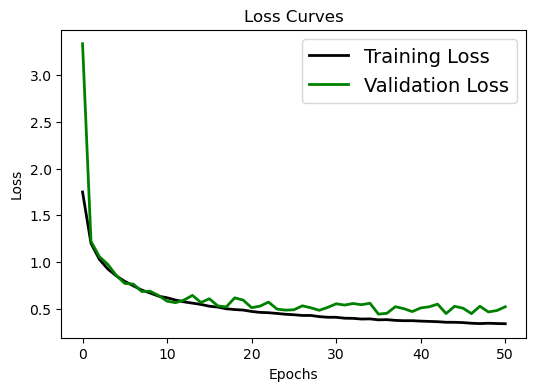

In [10]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)
plt.savefig("Loss curve")

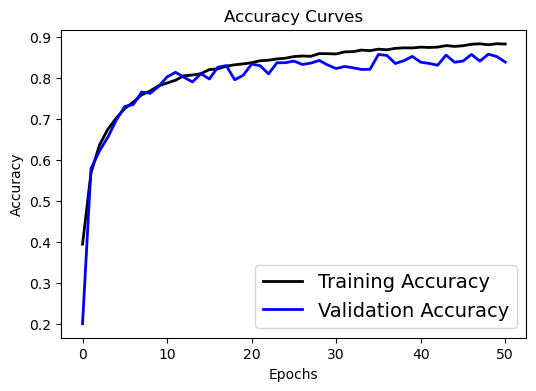

In [11]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)
plt.savefig("Accuracy curve")

In [21]:
def make_prediction(model, data, labels):
    # Making the Predictions
    pred = model.predict(data)
    # Converting the predictions into label index 
    pred_classes = np.argmax(pred, axis=1)
    
    accuracy = (np.argmax(labels, axis=1) == pred_classes)
    return accuracy.sum()/len(accuracy)


In [23]:
for history in all_histories:
    train_acc = make_prediction(history.model, train_images, train_labels)
    test_acc = make_prediction(history.model, test_images, test_labels)
    print(f"Train Accuracy: {train_acc}")
    print(f"Test Accuracy: {test_acc}")


313/313 [==============================] - 2s 5ms/step
Train Accuracy: 0.93804
Test Accuracy: 0.8653
313/313 [==============================] - 2s 5ms/step
Train Accuracy: 0.958
Test Accuracy: 0.8691
313/313 [==============================] - 2s 5ms/step
Train Accuracy: 0.94244
Test Accuracy: 0.8645
313/313 [==============================] - 2s 5ms/step
Train Accuracy: 0.93404
Test Accuracy: 0.8588
313/313 [==============================] - 2s 5ms/step
Train Accuracy: 0.923
Test Accuracy: 0.8566


In [24]:
train_acc = make_prediction(model, train_images, train_labels)
test_acc = make_prediction(model, test_images, test_labels)
print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")


313/313 [==============================] - 2s 5ms/step
Train Accuracy: 0.96834
Test Accuracy: 0.8711


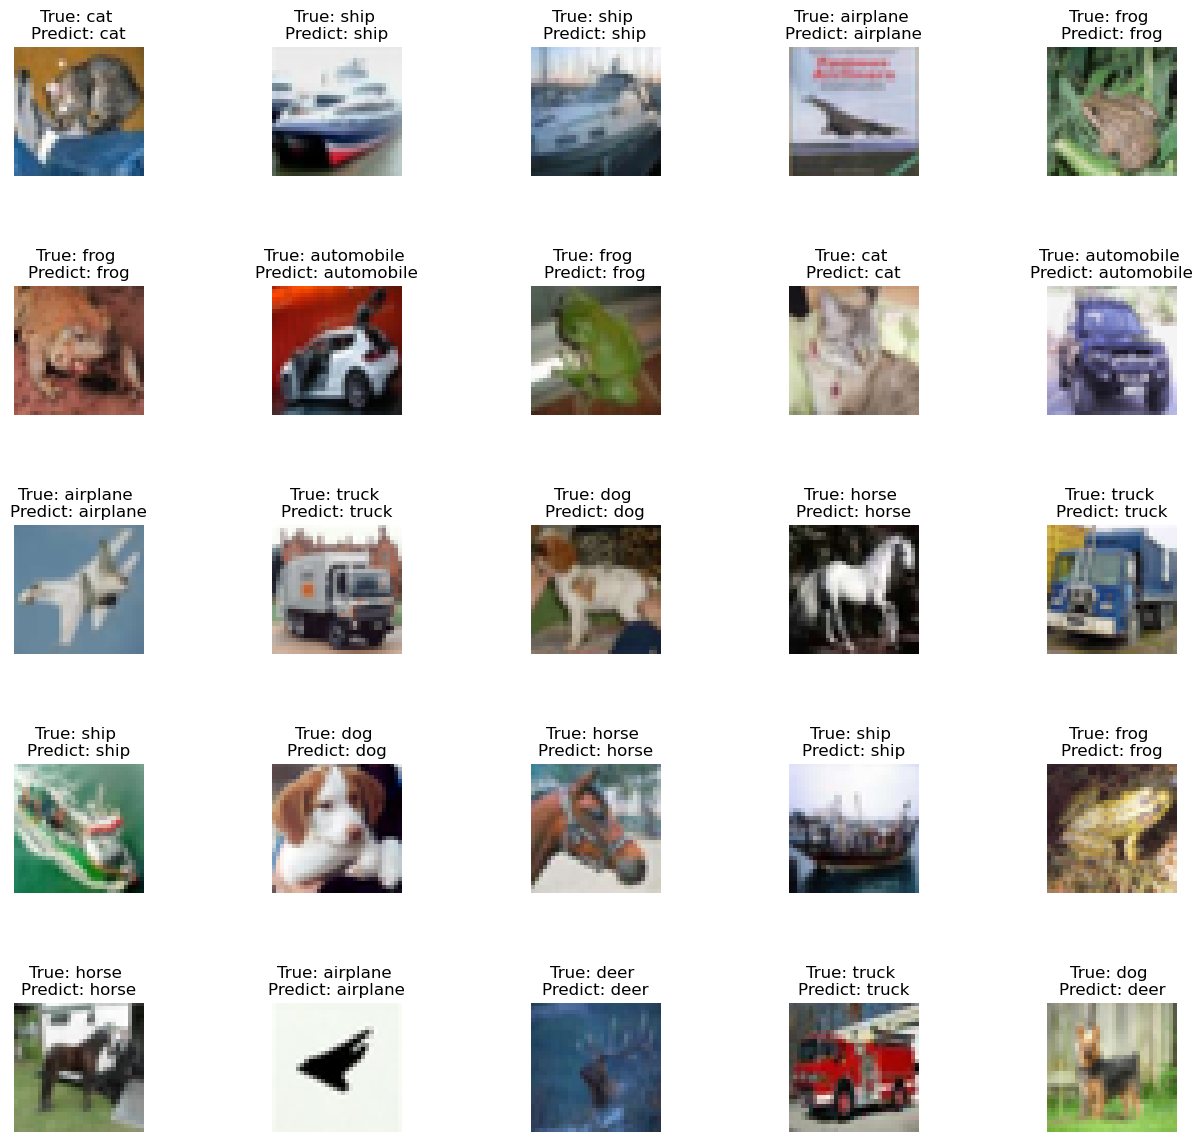

In [25]:
# Plotting the Actual vs. Predicted results

fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(test_images[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[np.argmax(test_labels[i])], class_names[pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

# Save model

In [24]:
import tensorflow as tf

all_histories[1].model.save("saved_model")
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

with open("model_cpu.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets
2024-01-29 02:27:43.886378: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-29 02:27:43.886401: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-29 02:27:43.889788: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model
2024-01-29 02:27:43.893880: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-29 02:27:43.893890: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model
2024-01-29 02:27:43.903279: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-29 02:27:43.906352: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-29 02:27:44.027127: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedMo

# Load Model

In [ ]:
import tensorflow as tf
from keras.datasets import cifar10
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
test_images = test_images.astype('float32')
test_images = test_images / 255 

interpreter = tf.lite.Interpreter(model_path="model_cpu.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


for index, image in enumerate(test_images[:10]):
    image = np.expand_dims(image, axis=0)
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_index = np.argmax(output_data)
    predicted_class_name = class_names[predicted_class_index]
    actual_class_name = class_names[test_labels.ravel()[index]]
    print(f"Predicted Class: {predicted_class_name} | Actual {actual_class_name}")